### Download the dataset

In [ ]:
import os
import shutil
try:
    shutil.rmtree("/content/hi")
except:
    pass

try:
    os.remove("/content/hi.zip")
except:
    pass

try:
    shutil.rmtree("/content/wandb")
except:
    pass

In [ ]:
%%capture
# !gdown https://drive.google.com/uc?id=1oG_Alz4wmqIMJxNPTZNuvYo1beMwTFHn
!gdown https://drive.google.com/uc?id=1TkaNm9ucnEn3S5Pz3D5SRFiroFgx4fjs
!unzip "/content/hi.zip"
!pip install wandb

In [ ]:
!nvidia-smi

Tue May 11 03:00:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.keras import WandbCallback
import seaborn as sns
from matplotlib.font_manager import FontProperties
%matplotlib inline

### Load the data

In [ ]:
# Load the training lexicons
with open("hi/lexicons/hi.translit.sampled.train.tsv") as f:
    training_lines = f.readlines()
training_pairs = [line.strip("\n").split("\t") for line in training_lines]
training_map = dict([(example[1], example[0]) for example in training_pairs])

# Load the validation lexicons
with open("hi/lexicons/hi.translit.sampled.dev.tsv") as f:
    validation_lines = f.readlines()
validation_pairs = [line.strip("\n").split("\t") for line in validation_lines]
validation_map = dict([(example[1], example[0]) for example in validation_pairs])

# Load the test lexicons
with open("hi/lexicons/hi.translit.sampled.test.tsv") as f:
    test_lines = f.readlines()
test_pairs = [line.strip("\n").split("\t") for line in test_lines]
test_map = dict([(example[1], example[0]) for example in test_pairs])

# Number of training examples
M_train = len(training_map.keys())

# Number of validation examples
M_val = len(validation_map.keys())

# Number of test examples
M_test = len(test_map.keys())

print(f"Number of training examples = {M_train}")
print(f"Number of validation examples = {M_val}")
print(f"Number of test examples = {M_test}")
print()

Number of training examples = 41345
Number of validation examples = 4321
Number of test examples = 4442



### Prepare the data

We have used "tab" for the START sequence character and "newline" as the END sequence character.

In [ ]:
def extract_data_info(data_dict):
    """
    Returns important information about the data.
    """
    input_words = []
    target_words = []
    input_characters = []
    target_characters = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")
        # Add the characters to the respective character lists
        input_characters = list(set(input_characters + list(key)))
        target_characters = list(set(target_characters + list(data_dict[key])))

    # Sort the input characters
    input_characters = sorted(list(set(input_characters)))
    # Sort the target characters
    target_characters = target_characters + ["\t", "\n"]
    target_characters = sorted(list(set(target_characters)))

    # Number of unique tokens in the source language
    num_input_tokens = len(input_characters)
    # Number of unique tokens in the target language
    num_target_tokens = len(target_characters)

    # Max input word length
    max_encoder_seq_length = max([len(word) for word in input_words]) 
    # Max output word length
    max_decoder_seq_length = max([len(word) for word in target_words])

    print(f"Number of unique input characters: {num_input_tokens}")
    print(f"Number of unique output characters: {num_target_tokens}")
    print()
    print(f"Maximum sequence length for the input: {max_encoder_seq_length}")
    print(f"Maximum sequence length for the output: {max_decoder_seq_length}")

    # Map characters to numerical indices (using +1 to avoid any character being mapped to 0)
    input_char_map = dict([(ch, i + 1) for i, ch in enumerate(input_characters)])
    target_char_map = dict([(ch, i + 1) for i, ch in enumerate(target_characters)])

    return input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map

def make_one_hot_arrays(data_dict, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens):
    """
    This function takes the training/validation/test dictionary as input and produces
    the one-hot encoded versions of the respective data.
    """
    input_words = []
    target_words = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")

    M = len(data_dict.keys())
    encoder_input_array = np.zeros((M, max_encoder_seq_length, num_input_tokens + 1), dtype="float")
    decoder_input_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")
    decoder_output_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")

    for i in range(M):
        source_word = input_words[i]
        target_word = target_words[i]

        # One-hot encoding for the input
        for j, ch in enumerate(source_word):
            encoder_input_array[i, j, input_char_map[ch]] = 1.0

        # One-hot encoding for the output
        for j, ch in enumerate(target_word):
            decoder_input_array[i, j, target_char_map[ch]]= 1.0
            if j >= 1:
                # The decoder output is one step ahead of the decoder input
                decoder_output_array[i, j-1, target_char_map[ch]] = 1.0

    # encoder_input_array = []
    # decoder_input_array = []
    # decoder_output_array = []

    # for i in range(M):
    #     source_word = input_words[i]
    #     target_word = target_words[i]

    #     # Numerical encoding for the source word
    #     encoder_input_array.append([input_char_map[ch] for ch in source_word])

    #     # One-hot encoding for the output
    #     decoder_input_array.append([target_char_map[ch] for ch in target_word])
    #     # The decoder output is one step ahead of the decoder input
    #     decoder_output_array.append([target_char_map[ch] for ch in target_word][1:])

    return input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array

In [ ]:
input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map = extract_data_info(training_map)

Number of unique input characters: 26
Number of unique output characters: 64

Maximum sequence length for the input: 20
Maximum sequence length for the output: 21


In [ ]:
# Get the one-hot training matrices
input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array = make_one_hot_arrays(training_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_encoder_input_array = keras.preprocessing.sequence.pad_sequences(encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_decoder_input_array = keras.preprocessing.sequence.pad_sequences(decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_decoder_output_array = keras.preprocessing.sequence.pad_sequences(decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_decoder_output_array_oh = np.zeros((padded_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_decoder_output_array_oh[i][j][padded_decoder_output_array[i][j]] = 1.0

In [ ]:
# Get the one-hot validation matrices
val_input_words, val_target_words, val_encoder_input_array, val_decoder_input_array, val_decoder_output_array = make_one_hot_arrays(validation_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_val_encoder_input_array = keras.preprocessing.sequence.pad_sequences(val_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_val_decoder_input_array = keras.preprocessing.sequence.pad_sequences(val_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_val_decoder_output_array = keras.preprocessing.sequence.pad_sequences(val_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_val_decoder_output_array_oh = np.zeros((padded_val_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_val_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_val_decoder_output_array_oh[i][j][padded_val_decoder_output_array[i][j]] = 1.0

In [ ]:
# Get the one-hot validation matrices
test_input_words, test_target_words, test_encoder_input_array, test_decoder_input_array, test_decoder_output_array = make_one_hot_arrays(test_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_test_encoder_input_array = keras.preprocessing.sequence.pad_sequences(test_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_test_decoder_input_array = keras.preprocessing.sequence.pad_sequences(test_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_test_decoder_output_array = keras.preprocessing.sequence.pad_sequences(test_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_test_decoder_output_array_oh = np.zeros((padded_test_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_test_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_test_decoder_output_array_oh[i][j][padded_test_decoder_output_array[i][j]] = 1.0

In [ ]:
# Using label encoding for the encoder inputs (and then find an embedding using the Embedding layer)
encoder_input_array = np.argmax(encoder_input_array, axis=2)
val_encoder_input_array = np.argmax(val_encoder_input_array, axis=2)
test_encoder_input_array = np.argmax(test_encoder_input_array, axis=2)

decoder_input_array = np.argmax(decoder_input_array, axis=2)
val_decoder_input_array = np.argmax(val_decoder_input_array, axis=2)
test_decoder_input_array = np.argmax(test_decoder_input_array, axis=2)

# Dictionaries mapping from indices to characters
reverse_input_char_map = dict((i, char) for char, i in input_char_map.items())
reverse_target_char_map = dict((i, char) for char, i in target_char_map.items())
reverse_target_char_map[0] = "\n"

In [ ]:
encoder_input_array[1]

array([ 1, 14, 11,  7,  1, 14,  9, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [ ]:
decoder_input_array[1]

array([ 1,  6,  4, 18, 20, 31, 52, 32,  2,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

### Define the model

Define Attention Layer

In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

Define the model

In [ ]:
def define_model(num_cells, cell_type, input_embedding_size, dropout_fraction, beam_size):
    """
    num_cells: Number of cells in the encoder and decoder layers
    cell_type: choice of cell type: Simple RNN, LSTM, GRU
    num_encoder_layers: Number of layers in the encoder
    num_decoder_layers: Number of layers in the decoder
    input_embedding_size: Dimenions of the vector to represent each character
    dropout_fraction: fraction of neurons to drop out
    """
    ## ENCODER
    # encoder_input = keras.Input(shape=(None, num_input_tokens), name="EncoderInput")
    encoder_input = keras.Input(shape=(None, ), name="EncoderInput")
    encoder_embedding = keras.layers.Embedding(num_input_tokens + 1, input_embedding_size, name="EncoderInputEmbedding", mask_zero=True)(encoder_input)

    #encoder lstm 1
    if cell_type == 'LSTM':
        encoder_lstm = tf.keras.layers.LSTM(num_cells,return_sequences=True,return_state=True,name="EncoderLayer" ,dropout=dropout_fraction,recurrent_dropout=dropout_fraction)
        encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
    if cell_type == 'GRU':
        encoder_gru = tf.keras.layers.GRU(num_cells,return_sequences=True,return_state=True,name="EncoderLayer" ,dropout=dropout_fraction,recurrent_dropout=dropout_fraction)
        encoder_output, gru_state = encoder_gru(encoder_embedding)
    if cell_type == 'RNN':
        encoder_rnn = tf.keras.layers.SimpleRNN(num_cells,return_sequences=True,return_state=True,name="EncoderLayer" ,dropout=dropout_fraction,recurrent_dropout=dropout_fraction)
        encoder_output, rnn_state = encoder_rnn(encoder_embedding)   

    ## DECODER
    decoder_input = keras.Input(shape=(None, ), name="DecoderInput")
    dec_emb = keras.layers.Embedding(num_target_tokens + 1, 64, name="DecoderInputEmbedding", mask_zero=True)(decoder_input)

    if cell_type == 'LSTM':
        decoder_lstm = tf.keras.layers.LSTM(num_cells, return_sequences=True, return_state=True, name="DecoderLayer" ,dropout=dropout_fraction,recurrent_dropout=dropout_fraction )
        decoder_output,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
    if cell_type == 'GRU':
        decoder_gru = tf.keras.layers.GRU(num_cells,return_sequences=True,return_state=True,name="DecoderLayer" ,dropout=dropout_fraction,recurrent_dropout=dropout_fraction)
        decoder_output, decoder_state_gru = decoder_gru(dec_emb,initial_state = gru_state)
    if cell_type =='RNN':
        decoder_rnn = tf.keras.layers.SimpleRNN(num_cells,return_sequences=True,return_state=True,name="DecoderLayer" ,dropout=dropout_fraction,recurrent_dropout=dropout_fraction)
        decoder_output, decoder_state_rnn = decoder_rnn(dec_emb,initial_state = rnn_state)

    # Attention layer
    attn_out, attn_states = AttentionLayer(name='attention_layer')([encoder_output, decoder_output])


    # Concat attention input and decoder LSTM output
    decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_output, attn_out])

    #dense layer
    decoder_dense =  tf.keras.layers.TimeDistributed(keras.layers.Dense(num_target_tokens + 1, activation='softmax'))
    #decoder_dense = keras.layers.Dense(num_target_tokens + 1, activation="softmax", name="DecoderDenseLayer") # Softmax picks one character
    decoder_outputs = decoder_dense(decoder_concat_input)

    # Define the model 
    model = keras.Model([encoder_input, decoder_input], decoder_outputs)

    return model

Inference model for 1 LSTM encoder - 1 LSTM decoder layers

In [ ]:
def prepare_inference_model_lstm_1(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output
    encoder_states = [encoder_outputs,state_h_enc, state_c_enc]

    # Create an encoder model 
    encoder_model = keras.Model(encoder_inputs, encoder_states)


    # Input to the decoder

    decoder_state_input_h = keras.Input(shape=(num_cells,))
    decoder_state_input_c = keras.Input(shape=(num_cells,))
    decoder_hidden_state_inputs = keras.Input(shape=(None,num_cells))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_inputs = model.layers[1].output
    decoder_embedding_layer = model.layers[3]
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    decoder_lstm = model.layers[5]

    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h_dec, state_c_dec]

    #attention
    attn_layer = model.layers[6]
    attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_inputs,decoder_outputs])

    #concat
    concate = model.layers[7]
    decoder_inf_concat = concate([decoder_outputs,attn_out_inf])

    # Softmax layer
    decoder_dense = model.layers[8]
    decoder_outputs = decoder_dense(decoder_inf_concat)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_hidden_state_inputs,decoder_state_input_h,decoder_state_input_c], [decoder_outputs] + decoder_states +[attn_states_inf])


    return encoder_model, decoder_model


def transliterate_word_lstm_1(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h, c,attn = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states[1],encoded_hidden_cell_states[2] = [h, c]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

Inference model for 1 RNN/GRU encoder - 1 RNN/GRU decoder layers

In [ ]:
def prepare_inference_model_rnngru_1(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    encoder_outputs, state_gru_enc = model.layers[4].output
    encoder_states = [encoder_outputs,state_gru_enc]

    # Create an encoder model 
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder

    decoder_state_input = keras.Input(shape=(num_cells,))
    decoder_hidden_state_inputs = keras.Input(shape=(None,num_cells))
    decoder_states_inputs = [decoder_state_input]

    decoder_inputs = model.layers[1].output
    decoder_embedding_layer = model.layers[3]
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    decoder_gru = model.layers[5]

    decoder_outputs, state_gru_dec = decoder_gru(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_gru_dec]


    #attention
    attn_layer = model.layers[6]
    attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_inputs,decoder_outputs])

    #concat
    concate = model.layers[7]
    decoder_inf_concat = concate([decoder_outputs,attn_out_inf])

    # Softmax layer
    decoder_dense = model.layers[8]
    decoder_outputs = decoder_dense(decoder_inf_concat)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_hidden_state_inputs,decoder_state_input], [decoder_outputs] + decoder_states +[attn_states_inf])

    return encoder_model, decoder_model


def transliterate_word_rnngru_1(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state, attn = decoder_model.predict([target_sequence] + [encoded_hidden_cell_states])

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states[1] = [state]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

### Training function (No WANDB)

Use this to train the model with the best choice of hyperparameters obtained from Wandb.

In [ ]:
def train(num_cells, cell_type, input_embedding_size, dropout_fraction, batch_size,epochs):
    """
    Function to train the model with the best set of hyperparameters (without WANDB)
    """
    # Define the model
    model = define_model(num_cells, cell_type, input_embedding_size, dropout_fraction, batch_size)
    print(model.summary())

    # Display a plot of the model
    keras.utils.plot_model(model)

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
            [encoder_input_array, decoder_input_array],
            decoder_output_array,
            batch_size = batch_size,
            epochs = epochs,
            verbose = 2,
            validation_data = ([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
            )

    # Save the trained model
    model.save("best_model.h5")

    if cell_type == "LSTM":
        cell = "lstm"
    else:
        cell = "rnngru"

    func1_name = "prepare_inference_model_" + cell + "_1"
    func2_name = "transliterate_word_" + cell + "_1" 

    # Get the encoder and decoder model
    encoder_model, decoder_model = globals()[func1_name](model, num_cells)

    outputs = []
    n = encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in target_words]
    # Calculate training accuracy
    training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Training accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))


    outputs = []
    n = val_encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = val_encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in val_target_words]
    # Calculate validation accuracy
    validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Validation accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))


    # Plots of accuracy and loss
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.plot(history.history["accuracy"], label = "Training accuracy")
    plt.title("Accuracy vs epoch", size=14)
    plt.legend()
    plt.show()

    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.plot(history.history["loss"], label = "Training loss")
    plt.title("Loss vs epoch", size=14)
    plt.legend()
    plt.show()


    return model, history

### Training with the Best Hyperparameters

These are the best hyperparameters that we got from WANDB.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
______________________________________________________________________________________________

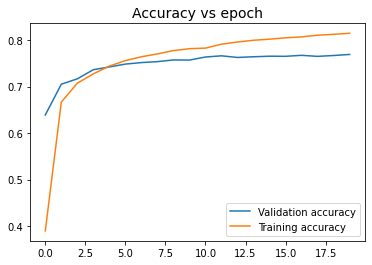

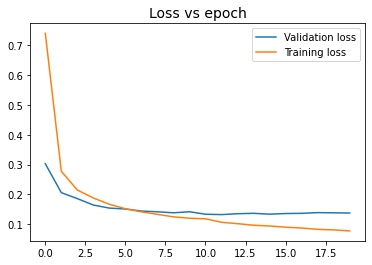

In [ ]:
# Best hyperparameters
num_cells = 512
cell_type = "GRU"
input_embedding_size = 64
dropout_fraction = 0.4
batch_size = 128
epochs = 20

model, history = train(num_cells, cell_type, input_embedding_size, dropout_fraction, batch_size,epochs)

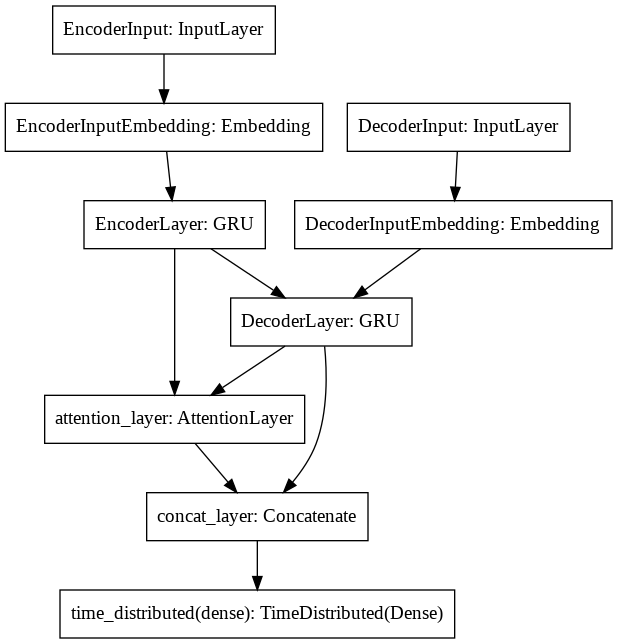

In [ ]:
keras.utils.plot_model(model)

## Inference Section

In [ ]:
!gdown --id 1g2bTbYAVLmc_IuKzTKOVqgLU7uvUE7dr #import Lohit-devanagri .ttf for matplotlib

### Inference for GRU/RNN

In [ ]:
encoder_model,decoder_model = prepare_inference_model_rnngru_1(model,num_cells)
outputs = []

n = test_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = test_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_rnngru_1(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in test_target_words]

df_test = pd.DataFrame({"Input": test_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate validation accuracy
test_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference test accuracy based on whole string matching = {} %".format(test_inference_accuracy*100.0))


Inference test accuracy based on whole string matching = 41.67041873030167 %


In [ ]:
df_test.to_csv('test_predictions',index=False)

In [ ]:

def transliterate_word_rnngru_attn_out(input_word,encoder_model,decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_word)

    target_sequence = np.zeros((1, 1, num_target_tokens))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[0, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)
    stop = False
    decoded_word = ""
    attention = []
    while not stop:
        output_tokens, h, attn = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)
        attention.append(attn)

        # Sample the most probable character using softmax outputs
        sampled_char_index = np.argmax(output_tokens[0, -1, :])

        sampled_char = reverse_target_char_map[sampled_char_index]
        decoded_word += reverse_target_char_map[sampled_char_index]

        # Stop when the maximum sequence length is reached or when the stop character is found.
        if sampled_char == "\n" or len(decoded_word) >= max_decoder_seq_length:
            stop = True

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((1, 1, num_target_tokens))
        target_sequence[0, 0, sampled_char_index] = 1.0
        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states[1] = [h]

    return decoded_word,attention

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


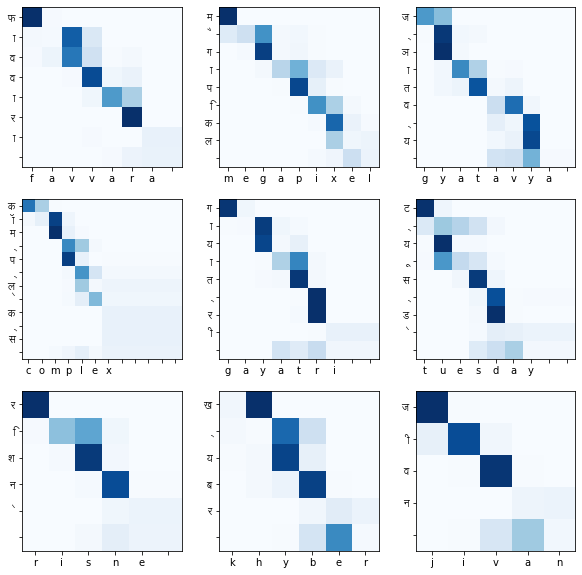

,Input,Ground Truth,Model output
0,favvara,फव्वारा,फाववारा
1,megapixel,मेगापिक्सल,मैगापिकल
2,gyatavya,ज्ञातव्य,ज्ञातव्य
3,complex,कॉम्प्लेक्स,कॉम्प्लेक्स
4,gayatri,गायत्री,गायात्री
5,tuesday,ट्यूजडे,ट्यूस्डे
6,risne,रिसने,रिशने
7,khyber,ख़ैबर,ख्यबर
8,jivan,जीवन,जीवन


In [ ]:
ground_truth = []
queries = []
outputs = []

random_indices = [np.random.randint(0, M_test) for i in range(9)]

fig = plt.figure(figsize=(10,10))

index=1
attentions = []
for i in random_indices:
    query = test_encoder_input_array[i:i+1]
    decoded_word,attention = transliterate_word_rnngru_attn_out(query,encoder_model,decoder_model)

    attention = np.array(attention)
    plt.subplot(3,3,index)
    plt.imshow(attention.reshape(attention.shape[0],attention.shape[-1])[:,:len(decoded_word)],cmap="Blues")

    plt.yticks(range(attention.shape[0]),decoded_word,fontproperties=FontProperties(fname = 'Lohit-Devanagari.ttf'))
    plt.xticks(range(attention.shape[0]),test_input_words[i])

    queries.append(test_input_words[i])
    outputs.append(decoded_word.strip("\n"))
    attentions.append(attention.reshape(attention.shape[0],attention.shape[-1])[:,:len(decoded_word)])
    ground_truth.append(test_target_words[i][1:-1]) # To remove the tab and newline characters
    index+=1
plt.show()

df_train = pd.DataFrame({"Input": queries, "Ground Truth" : ground_truth, "Model output":outputs})
df_train

### Other Utilities

### Plot .GIF

फाववारा


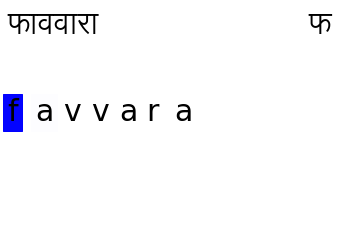

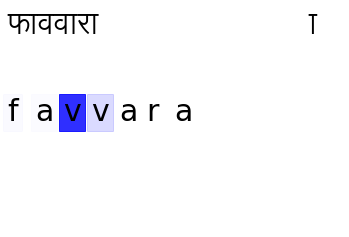

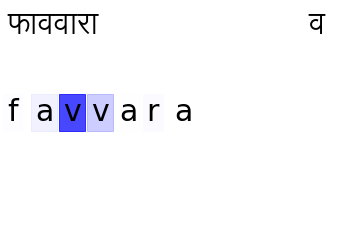

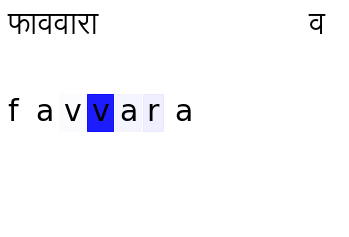

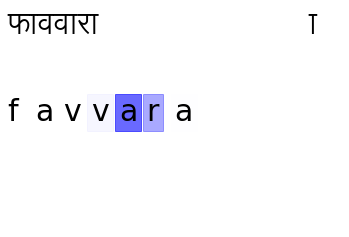

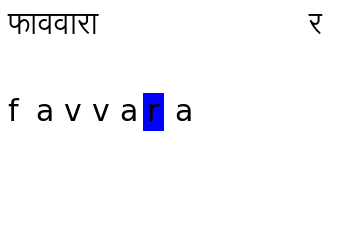

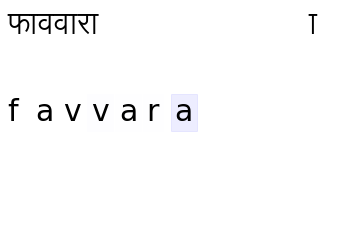


[MoviePy] Building file conn0.gif with imageio


 88%|████████▊ | 7/8 [00:00<00:00, 64.39it/s]

मैगापिकल


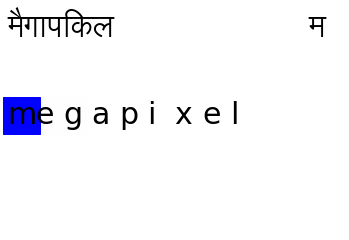

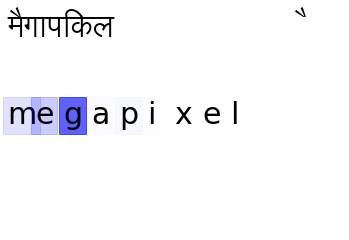

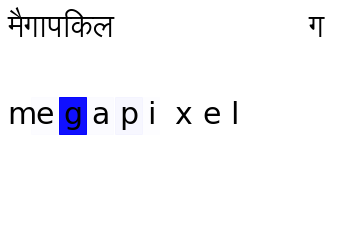

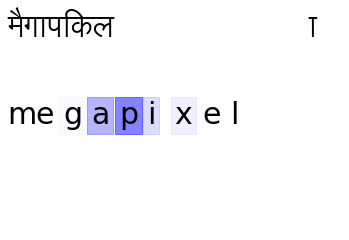

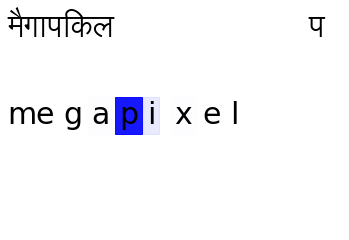

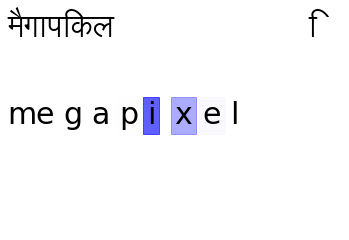

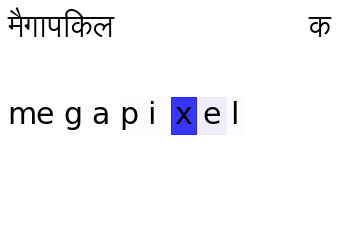

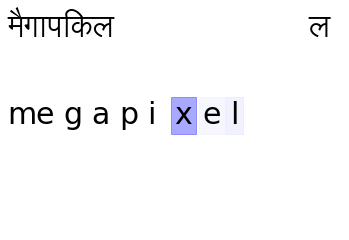


[MoviePy] Building file conn1.gif with imageio


100%|██████████| 8/8 [00:00<00:00, 57.77it/s]

ज्ञातव्य


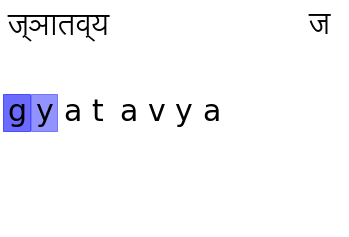

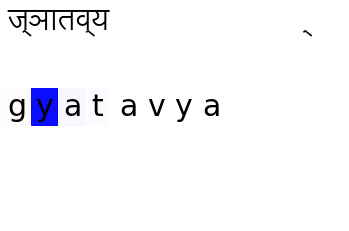

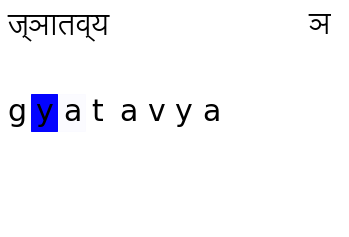

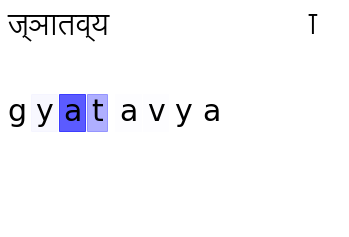

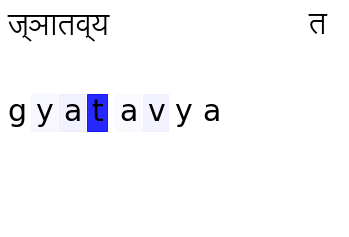

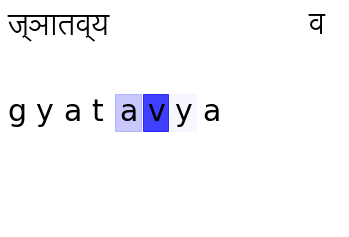

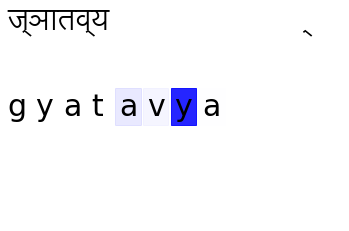

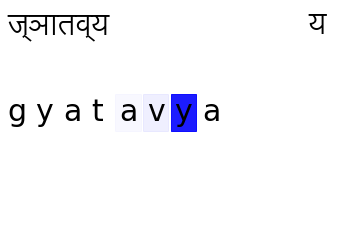


[MoviePy] Building file conn2.gif with imageio


100%|██████████| 8/8 [00:00<00:00, 52.09it/s]

कॉम्प्लेक्स


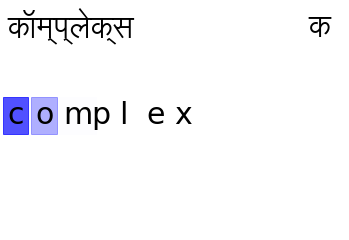

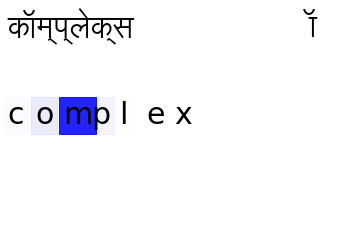

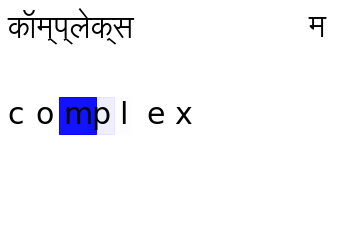

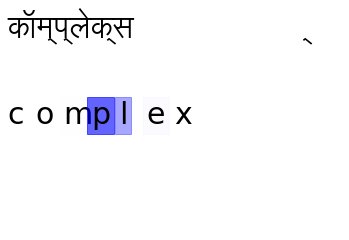

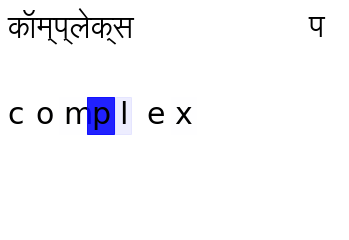

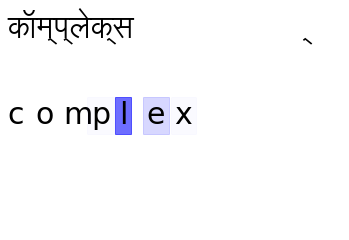

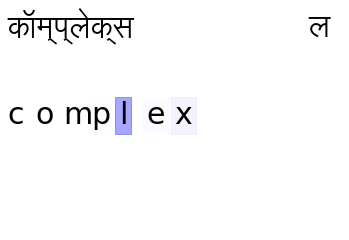

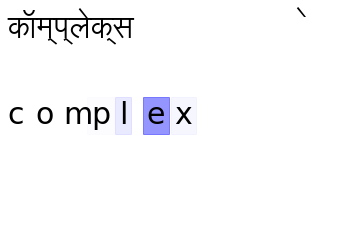

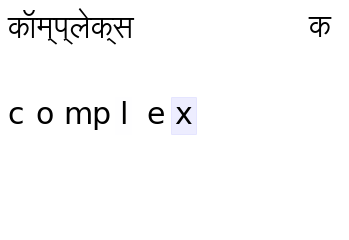

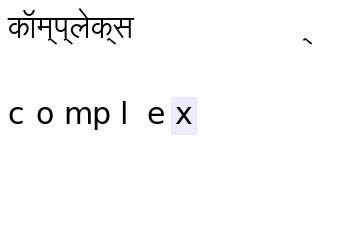

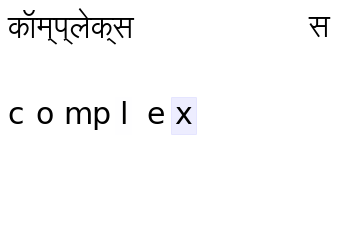


[MoviePy] Building file conn3.gif with imageio


100%|██████████| 11/11 [00:00<00:00, 51.97it/s]

गायात्री


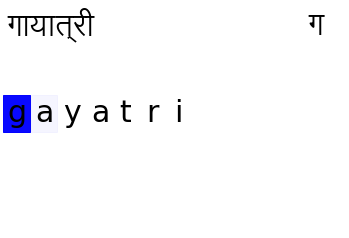

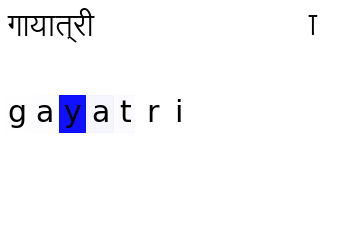

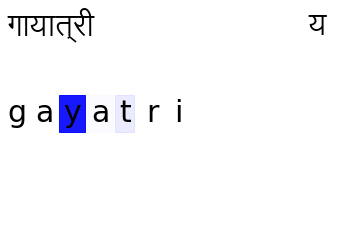

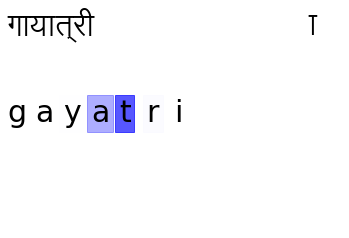

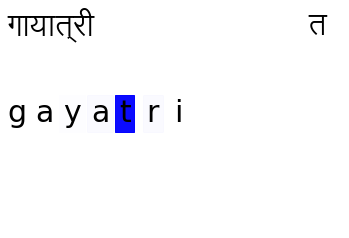

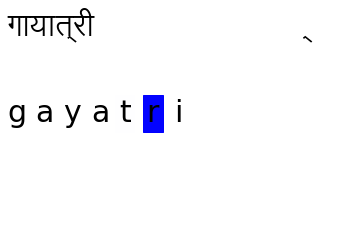

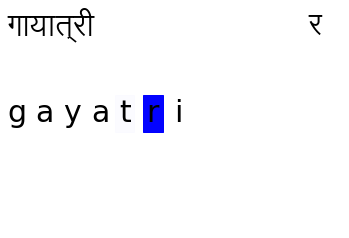

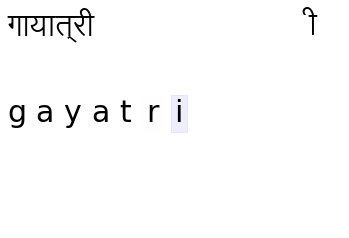


[MoviePy] Building file conn4.gif with imageio


100%|██████████| 8/8 [00:00<00:00, 59.49it/s]

ट्यूस्डे


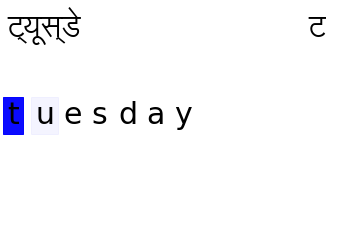

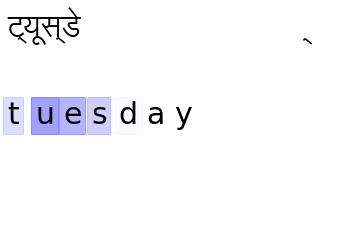

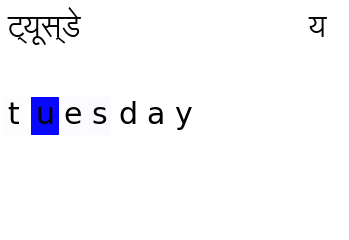

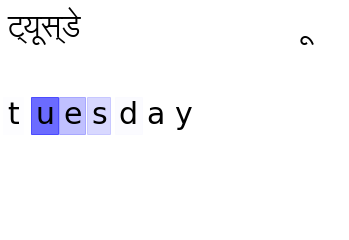

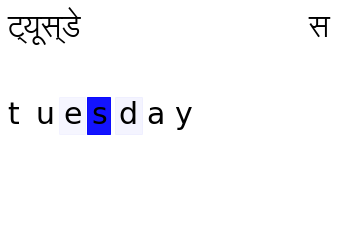

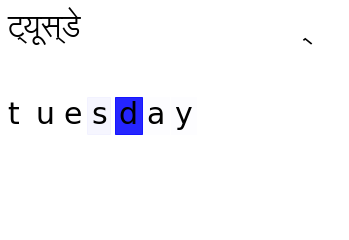

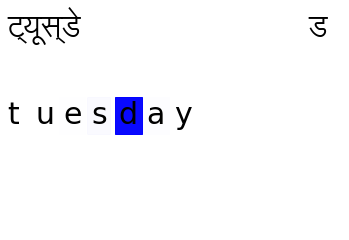

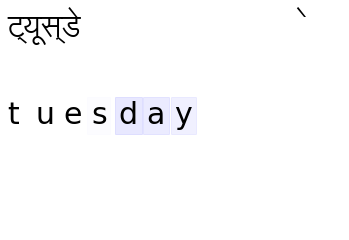


[MoviePy] Building file conn5.gif with imageio


100%|██████████| 8/8 [00:00<00:00, 54.01it/s]

रिशने


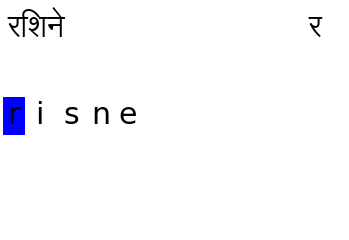

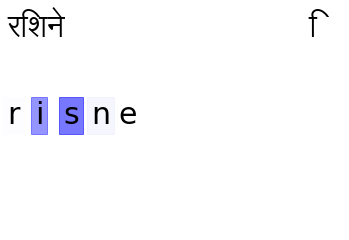

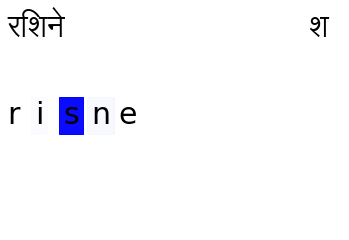

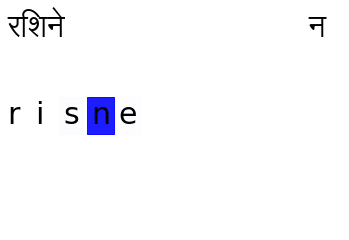

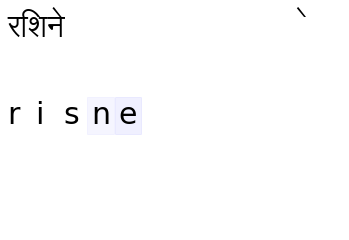


[MoviePy] Building file conn6.gif with imageio


 83%|████████▎ | 5/6 [00:00<00:00, 59.89it/s]

ख्यबर


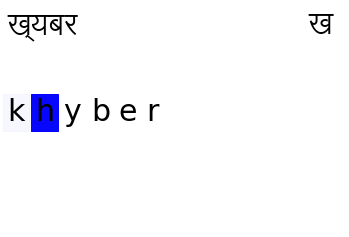

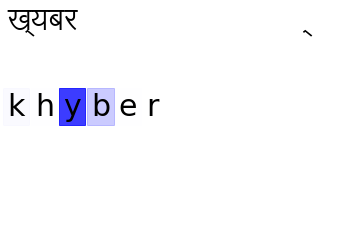

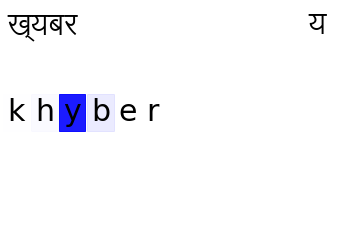

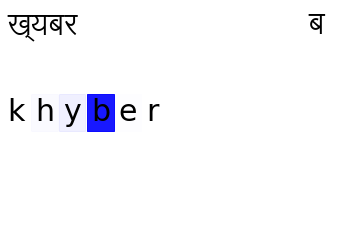

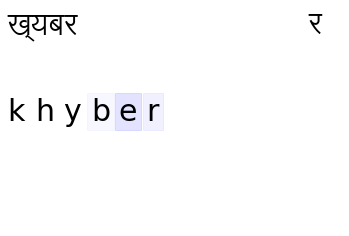


[MoviePy] Building file conn7.gif with imageio


 83%|████████▎ | 5/6 [00:00<00:00, 57.93it/s]

जीवन


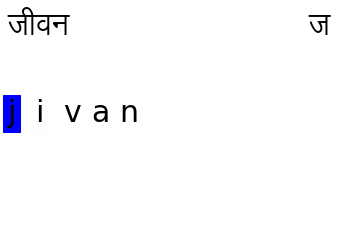

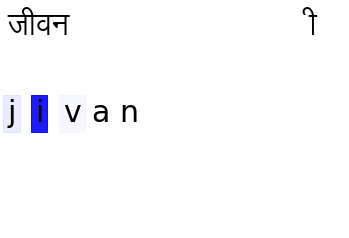

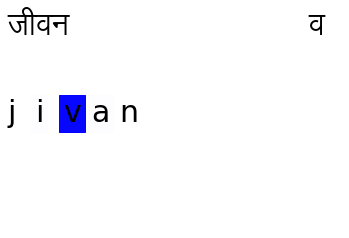

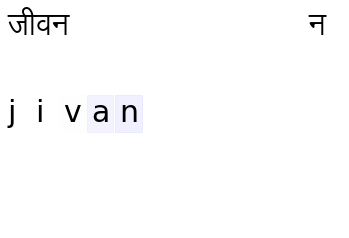


[MoviePy] Building file conn8.gif with imageio


 80%|████████  | 4/5 [00:00<00:00, 55.95it/s]


In [ ]:
import warnings
import cv2 as cv
#!pip install moviepy
from moviepy.editor import ImageSequenceClip



for num in range(9):
  word = df_train.iloc[num,2]
  print(word)
  frames =[]

  org = df_train.iloc[num,0]
  warnings.filterwarnings('ignore')
  for i in range(len(word)):
    plt.text(0,0.9,word,fontproperties=FontProperties(fname = 'Lohit-Devanagari.ttf'),fontsize = 30)
    plt.text(0.9,0.9,word[i],fontproperties=FontProperties(fname = 'Lohit-Devanagari.ttf'),fontsize = 30)
    plt.axis('off')

    alphas = attentions[num][i]
    for j in range(len(org)):
      t=plt.text(0.5*(j/6),0.5,org[j],fontsize=30)
      t.set_bbox(dict(facecolor='blue', alpha=alphas[j], edgecolor='blue'))
    plt.savefig('saved_figure.png')
    plt.show()
    frames.append(cv.cvtColor(cv.imread('saved_figure.png'), cv.COLOR_BGR2RGB ))  

  clip = ImageSequenceClip(frames, fps=5)
  clip.write_gif('conn' + str(num)+'.gif', fps=5)

### Inference for LSTM-based network

In [ ]:
encoder_model,decoder_model = prepare_inference_model_lstm_1(model,num_cells)
outputs = []

n = test_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = test_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_lstm_1(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in test_target_words]

df_test = pd.DataFrame({"Input": test_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate test accuracy
test_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference test accuracy based on whole string matching = {} %".format(test_inference_accuracy*100.0))

In [ ]:
def transliterate_word_lstm_attn_out(input_word,encoder_model,decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_word)

    target_sequence = np.zeros((1, 1, num_target_tokens))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[0, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)
    stop = False
    decoded_word = ""
    attention = []
    while not stop:
        output_tokens, h, c,attn = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)
        attention.append(attn)

        # Sample the most probable character using softmax outputs
        sampled_char_index = np.argmax(output_tokens[0, -1, :])

        sampled_char = reverse_target_char_map[sampled_char_index]
        decoded_word += reverse_target_char_map[sampled_char_index]

        # Stop when the maximum sequence length is reached or when the stop character is found.
        if sampled_char == "\n" or len(decoded_word) >= max_decoder_seq_length:
            stop = True

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((1, 1, num_target_tokens))
        target_sequence[0, 0, sampled_char_index] = 1.0
        target_sequence = np.argmax(target_sequence, axis=2)


        # Update the hidden state and cell state 
        encoded_hidden_cell_states[1],encoded_hidden_cell_states[2] = [h, c]

    return decoded_word,attention

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


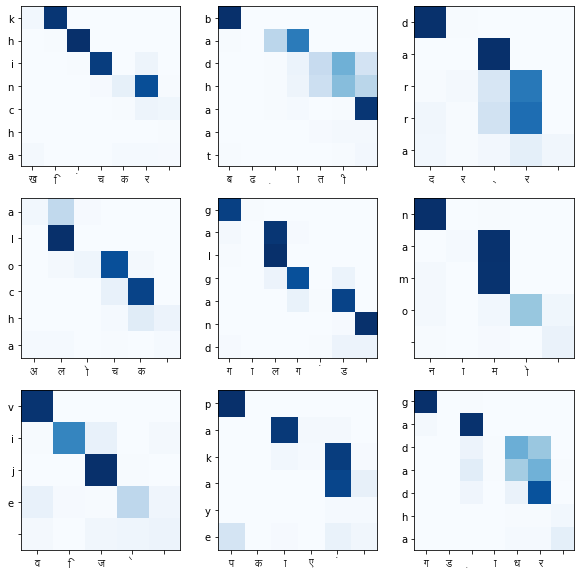

,Input,Ground Truth,Model output
0,khinchakar,खिंचकर,खिंचकर
1,badhaati,बढ़ाती,बढ़ाती
2,darra,दर्रा,दर्र
3,alochak,आलोचक,अलोचक
4,galgand,गलगंड,गालगंड
5,namo,नामो,नामो
6,vije,वाइज,विजे
7,pakayen,पकाएं,पकाएं
8,gadadhar,गदाधर,गड़ाधर


In [ ]:
ground_truth = []
queries = []
outputs = []

random_indices = [np.random.randint(0, M_test) for i in range(9)]

fig = plt.figure(figsize=(10,10))

index=1
for i in random_indices:
    query = test_encoder_input_array[i:i+1]
    decoded_word,attention = transliterate_word_lstm_attn_out(query,encoder_model,decoder_model)

    attention = np.array(attention)
    plt.subplot(3,3,index)
    plt.imshow(attention.reshape(attention.shape[0],attention.shape[-1])[:,:attention.shape[0]],cmap="Blues")
    plt.xticks(range(attention.shape[0]),decoded_word,fontproperties=FontProperties(fname = 'Lohit-Devanagari.ttf'))
    plt.yticks(range(attention.shape[0]),test_input_words[i])
    queries.append(test_input_words[i])
    outputs.append(decoded_word.strip("\n"))
    ground_truth.append(test_target_words[i][1:-1]) # To remove the tab and newline characters
    index+=1
plt.show()

df_train = pd.DataFrame({"Input": queries, "Ground Truth" : ground_truth, "Model output":outputs})
df_train